# Lloyd-Max quantization

* Minimizes the [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) of the quantization error, i.e., the expectation of the power of the quantization error, i.e. 
\begin{equation}
 D = \text{E}[(\mathbf{x}-\mathbf{y})^2],
\end{equation}
where $D$ is the distortion generated by the quantizer, $\mathbf{x}$ is the original signal, and $\mathbf{y}$ is the reconstructed signal.
* The PDF (in the analog case) or the histogram (digital signals) is required. The density of quantization bins is higher in those parts of the input dynamic range where the probability of the samples is also higher.
* The quantizer must determine the decision levels, and the representation levels.
* Inside of a bin (quantization step), the PDF/histogram is supposed to be constant. *For this reason, we select the representation level of each bin just in the middle point. This is the *


## Adaptive quantization using the PDF
In the continuous case, if $M$ is the number of bins, the distortion can be expressed by
\begin{equation}
D = \sum_{i=1}^{M}\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}(\mathbf{x}-\mathbf{c}_i)^2P(x)dx,
\end{equation}
where $\mathbf{b}_i$ is the upper decision level of the $i$-th bin, $\mathbf{c}_i$ is the representation level for the $i$-th bin, and $P(x)=f_\mathbf{x}(x)$ is the probability of finding $x$ in the signal (considered as a random variable) $\mathbf{x}$.

To minimize $D$ we must solve
\begin{equation}
\frac{\partial D}{\partial \mathbf{c}_i} = 0 = -\sum_{i=1}^M\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}2(\mathbf{x}-\mathbf{c}_i)^2P(x)dx
\end{equation}
which boilds down to
\begin{equation}
= -\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}2(\mathbf{x}-\mathbf{c}_i)^2P(x)dx
\end{equation}
because $\mathbf{c}_i$ is only used in one of the bins. We continue
\begin{equation}
= 2\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}\mathbf{x}P(x)dx - 2\mathbf{c}_i\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}P(x)dx.
\end{equation}
Therefore:
\begin{equation}
\mathbf{c}_i = \frac{\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}\mathbf{x}P(x)dx}{\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}P(x)dx},\tag{1}
\end{equation}
i.e., the representation level $\mathbf{c}_i$ for each bin is the centroid of the probability mass in that bin. Notice that, in order to avoid a division by 0, at least one one sample must belong to each bin.

Unfortunately, such equation express that, to find the representation levels $\mathbf{c}_i$, we must determine first the decision levels $\mathbf{b}_i$. For computing them, we can now minimize $D$ respect to $\mathbf{b}_i$:
\begin{equation}
\frac{\partial D}{\partial \mathbf{b}_i} = 0,
\end{equation}
which, supposing that the bins are small enough to consider that the probability of the values of $\mathbf{x}$ is constant inside of each bin, ends up in that:
\begin{equation}
\mathbf{b}_i = \frac{\mathbf{c}_i+\mathbf{c}_{i+1}}{2},\tag{2}
\end{equation}
a result quite logical under such supposition.

## Computation of the representation levels.

Unfortunately, Equations (1) and (2) are mutually dependent. However, they can be used to compute $\{\mathbf{y}_k\}_{k=1}^M$ and $\{\mathbf{b}_k\}_{k=0}^M$ using the following iterative algorithm:

0. Define $\epsilon>0$.
1. Initialize $\mathbf{c}_k$ /* centroids */ at random.
2. Let $\mathbf{previous\_b}=\{\mathbf{previous\_d}_k\}_{k=0}^M=0$ /* boundaries */.
2. While $ max(|\mathbf{previous\_b}-\mathbf{b}|) > \epsilon$:
    1. $\mathbf{previous\_b}\leftarrow \mathbf{b}$.
    1. Compute the boundary (decision) levels $\mathbf{b}$ using Eq. (2).
    2. Update the centroids (representation levels) $\mathbf{c}$ using Eq. (1).

In [1]:
import numpy as np
from scipy.ndimage import uniform_filter1d
uniform_filter1d([2.0, 8, 0, 4, 1, 9, 9.0, 0], size=2, origin=-1)
uniform_filter1d([0, 128, 256], size=2, origin=-1)[:-1]
print(uniform_filter1d([64, 192], size=2, origin=-1)[:-1])
print(uniform_filter1d([64, 192], size=2, mode="nearest"))

[128]
[ 64 128]


In [2]:
from scipy.ndimage import center_of_mass
x = np.array([1,2,3,4,5])
center_of_mass(x)

x = np.array([1,1,1,1,1])
center_of_mass(x)[0]

2.0

In [3]:
def compute_boundaries(c):
    b = uniform_filter1d(c, size=2, origin=-1)[:-1]
    b = np.concatenate(([0],b,[256]))
    #b = np.concatenate(([0],b))
    print('b', b)
    return b

In [4]:
def compute_centroids(b, P, M):
    c = []
    bin_size = P.size//M
    print("bin_size", bin_size)
    for i in range(M):
        b_i = i*bin_size
        b_i_1 = (i+1)*bin_size
        print("b_i", b_i, "b_i_1", b_i_1)
        # See from scipy.ndimage import center_of_mass
        mass = np.sum([j*P[j] for j in range(b_i, b_i_1)])
        total_counts_in_bin = np.sum([P[j] for j in range(b_i, b_i_1)])
        #if total_counts_in_bin > 0:
        centroid = mass/total_counts_in_bin
        #print("1", centroid, b_i, b_i_1)
        #centroid = center_of_mass(b[i+1]*P[b_i:b_i_1])[0]
        #print("2", centroid, b[i])
        #else:
        #    centroid = mass/bin_size
        c.append(centroid)
    #print('>c', np.array(c))
    return np.array(c)

In [5]:
def compute_levels(P, epsilon, max_iters, M, min_val, max_val):
    initial_boundaries = np.linspace(min_val, max_val + 1, M + 1)
    initial_centroids = 0.5 * (initial_boundaries[1:] + initial_boundaries[:-1])
    #initial_centroids = np.concatenate(([0], initial_centroids))
    c = initial_centroids
    #print('c', c)
    b = initial_boundaries
    print('b', b)
    prev_b = np.zeros(b.size)
    print('prev_b', prev_b)
    #print(M)
    for j in range(max_iters):
        print('j', j)
        prev_b[:] = b
        b = compute_boundaries(c)
        max_abs_error = np.max(np.abs(prev_b-b))
        print("max_abs_error", max_abs_error)
        if (j>0) and (max_abs_error <= epsilon):
            break
        c = compute_centroids(b, P, M)
    return b, c

### Build a quantizer

In [6]:
P = np.ones(256) # Counts for uniform distribution
#P = np.random.randint(low=0, high=2000, size=256)
epsilon = 1e-5
max_iters = 100
min_val = 0
max_val = 255
M = 2
boundaries, centroids = compute_levels(P, epsilon, max_iters, M, min_val, max_val)
print('boundaries', boundaries)
print('centroids', centroids)

b [  0. 128. 256.]
prev_b [0. 0. 0.]
j 0
b [  0. 128. 256.]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
j 1
b [  0.  127.5 256. ]
max_abs_error 0.5
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
j 2
b [  0.  127.5 256. ]
max_abs_error 0.0
boundaries [  0.  127.5 256. ]
centroids [ 63.5 191.5]


## Quantize an array that follows an uniform distribution

### Define the data to quantize

In [7]:
x = np.linspace(0, 255, 256)
x

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [8]:
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    #plt.rcParams['text.usetex'] = True
    #plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
%matplotlib inline

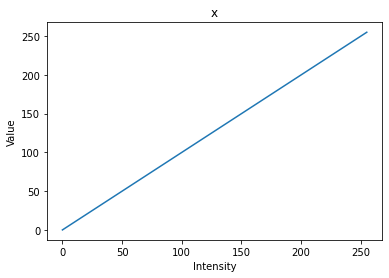

In [9]:
plt.figure()
plt.title("x")
plt.xlabel("Intensity")
plt.ylabel("Value")
plt.plot(x)

### Compute the histogram(x)

In [10]:
histogram_x, bin_edges_x = np.histogram(x, bins=256, range=(0, 256))
histogram_x

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

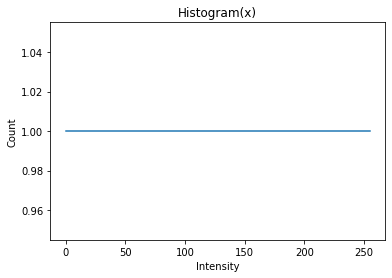

In [11]:
plt.figure()
plt.title("Histogram(x)")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.plot(bin_edges_x[0:-1], histogram_x)

## Encode(x)

In [12]:
k = np.searchsorted(boundaries, x, side="right") - 1
k

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

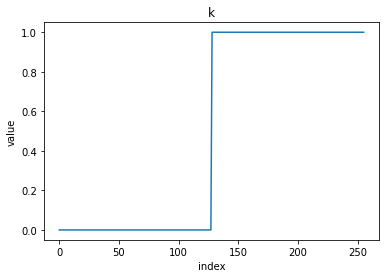

In [13]:
plt.figure()
plt.title("k")
plt.xlabel("index")
plt.ylabel("value")
plt.plot(k)

### Decode(k)

In [14]:
y = centroids[k]
y

array([ 63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,

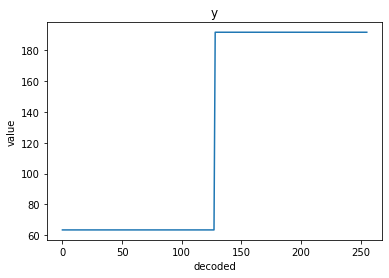

In [15]:
plt.figure()
plt.title("y")
plt.xlabel("decoded")
plt.ylabel("value")
plt.plot(y)

## Quantize an image

### Stuff for reading gray-scale images

In [16]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

"/home/vruiz/repos" exists


In [17]:
%%bash
if [ -d "$HOME/repos/image_IO" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/image_IO ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/image_IO.git
fi

/home/vruiz/repos/image_IO ... 
Ya está actualizado.


In [18]:
%%bash
if [ -d "$HOME/repos/information_theory" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/information_theory ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/information_theory.git
fi

/home/vruiz/repos/information_theory ... 
Ya está actualizado.


In [19]:
!ln -sf ~/repos/image_IO/image_1.py .
!ln -sf ~/repos/image_IO/logging_config.py .

In [20]:
import image_1 as gray_image
import os

In [21]:
home = os.environ["HOME"]
fn = home + "/repos/MRVC/images/lena_bw/"
#fn = home + "/repos/MRVC/images/circle/"
#fn = home + "/repos/MRVC/images/Hommer_bw/"
!ls -l {fn}

gray_image.write = gray_image.debug_write

total 148
-rw-r--r-- 1 vruiz vruiz 151199 feb 18  2022 000.png


### Read the image

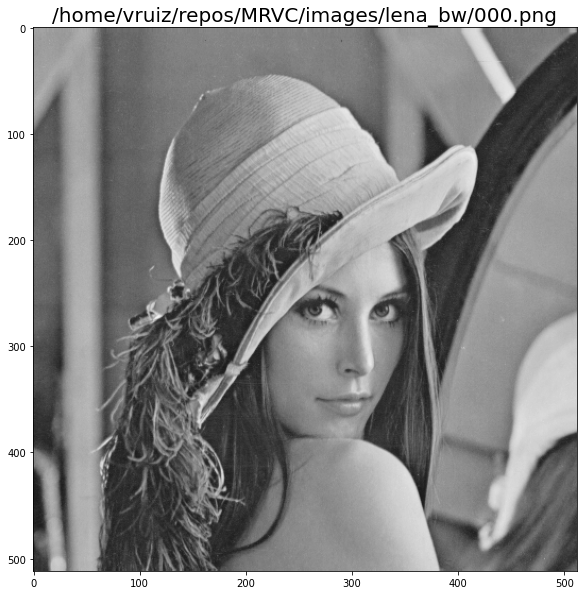

In [22]:
img = gray_image.read(fn, 0)
gray_image.show(img, fn + "000.png")

### Histogram of the image

In [23]:
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 256))
histogram[histogram==0] = 1
print("histogram", histogram, "\nbin_edges", bin_edges)
print(len(histogram))

histogram [   1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    7   22
   28   63   93  135  177  224  306  420  508  607  778  922 1082 1279
 1429 1642 1756 1846 2038 2066 2007 2081 2053 2039 1969 1846 1741 1673
 1549 1478 1289 1249 1193 1026  959  948  910  868  786  801  771  776
  848  812  820  801  880  903  850  890  938  935  916  924  847  951
  935  965  994 1015 1072 1108 1124 1224 1194 1346 1413 1557 1628 1791
 1853 2105 1930 1899 1941 1840 1763 1737 1588 1498 1466 1336 1369 1389
 1363 1442 1381 1336 1409 1464 1544 1517 1626 1789 1790 1878 2061 2097
 2311 2300 2385 2483 2390 2262 2235 2116 1993 1858 1929 1889 2040 2128
 2270 2270 2341 2433 2466 2409 2214 2340 2285 2202 2314 2327 2374 2611
 2723 2690 2673 2493 2391 2286 2062 1846 1769 1628 1454 1403 1370 1247
 1201 1241 1139 1187 1350 1242 1225 1184 1190 1236 1108  950  919  820
  790  681  626  619  641  691  647  664  726  815  825  912  926 1

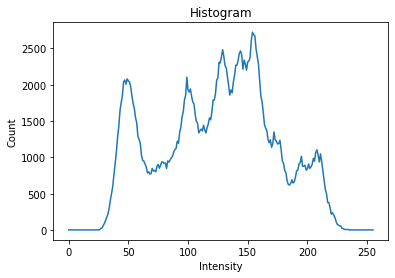

In [24]:
plt.figure()
plt.title("Histogram")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.plot(bin_edges[0:-1], histogram)

### Build the quantizer

In [25]:
P = histogram
epsilon = 1e-5
max_iters = 100
min_val = 0
max_val = 255
M = 128
boundaries, centroids = compute_levels(P, epsilon, max_iters, M, min_val, max_val)

b [  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198. 200. 202. 204. 206. 208. 210. 212. 214. 216. 218. 220. 222.
 224. 226. 228. 230. 232. 234. 236. 238. 240. 242. 244. 246. 248. 250.
 252. 254. 256.]
prev_b [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [26]:
print(boundaries)

[  0.           1.5          3.5          5.5          7.5
   9.5         11.5         13.5         15.5         17.5
  19.5         21.5         23.5         25.62931034  27.72546419
  29.64220648  31.57535438  33.56855794  35.56145351  37.54337378
  39.54203628  41.53819943  43.52358616  45.50795218  47.50623109
  49.50367011  51.49108438  53.48696022  55.48915661  57.490196
  59.47724511  61.47974316  63.49265243  65.49645744  67.50317096
  69.49538633  71.49164802  73.50029461  75.50897203  77.5053467
  79.50068653  81.51554747  83.51840788  85.50656061  87.50674168
  89.5147758   91.52560799  93.52708184  95.5240399   97.52783582
  99.5138931  101.49129785 103.49146473 105.49085187 107.48111015
 109.49021405 111.50885391 113.5029004  115.50064534 117.50258078
 119.50972749 121.51793047 123.50816232 125.5015681  127.50443647
 129.49815411 131.48628373 133.48439853 135.48861687 137.50265914
 139.50527831 141.50481776 143.50189469 145.50399392 147.50229253
 149.49607581 151.51258594 

In [27]:
print(centroids)

[  0.5          2.5          4.5          6.5          8.5
  10.5         12.5         14.5         16.5         18.5
  20.5         22.5         24.5         26.75862069  28.69230769
  30.59210526  32.55860349  34.5785124   36.54439462  38.54235294
  40.54171961  42.53467926  44.51249306  46.50341131  48.50905088
  50.49828935  52.48387942  54.49004101  56.48827222  58.49211978
  60.46237044  62.49711589  64.48818898  66.5047259   68.50161603
  70.48915663  72.49413942  74.5064498   76.51149425  78.49919915
  80.50217391  82.52892102  84.50789474  86.50522648  88.50825688
  90.52129472  92.52992126  94.52424242  96.52383738  98.53183426
 100.49595195 102.48664375 104.49628571 106.48541802 108.47680228
 110.50362582 112.514082   114.49171881 116.50957188 118.49558968
 120.5238653  122.51199564 124.504329   126.4988072  128.51006574
 130.48624248 132.48632498 134.48247209 136.49476166 138.51055662
 140.5        142.50963553 144.49415385 146.51383399 148.49075106
 150.50140056 152.523771

In [53]:
print(histogram)

array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    7,   22,   28,   63,   93,  135,  177,
        224,  306,  420,  508,  607,  778,  922, 1082, 1279, 1429, 1642,
       1756, 1846, 2038, 2066, 2007, 2081, 2053, 2039, 1969, 1846, 1741,
       1673, 1549, 1478, 1289, 1249, 1193, 1026,  959,  948,  910,  868,
        786,  801,  771,  776,  848,  812,  820,  801,  880,  903,  850,
        890,  938,  935,  916,  924,  847,  951,  935,  965,  994, 1015,
       1072, 1108, 1124, 1224, 1194, 1346, 1413, 1557, 1628, 1791, 1853,
       2105, 1930, 1899, 1941, 1840, 1763, 1737, 1588, 1498, 1466, 1336,
       1369, 1389, 1363, 1442, 1381, 1336, 1409, 1464, 1544, 1517, 1626,
       1789, 1790, 1878, 2061, 2097, 2311, 2300, 2385, 2483, 2390, 2262,
       2235, 2116, 1993, 1858, 1929, 1889, 2040, 2128, 2270, 2270, 2341,
       2433, 2466, 2409, 2214, 2340, 2285, 2202, 23

## Encode(x)

In [29]:
indexes = np.searchsorted(boundaries, img) - 1

In [30]:
print(indexes.shape, np.min(indexes), np.max(indexes))

(512, 512) 12 122


In [31]:
print(np.unique(indexes))

[ 12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 119 121
 122]


In [32]:
print(len(np.unique(indexes)))

109


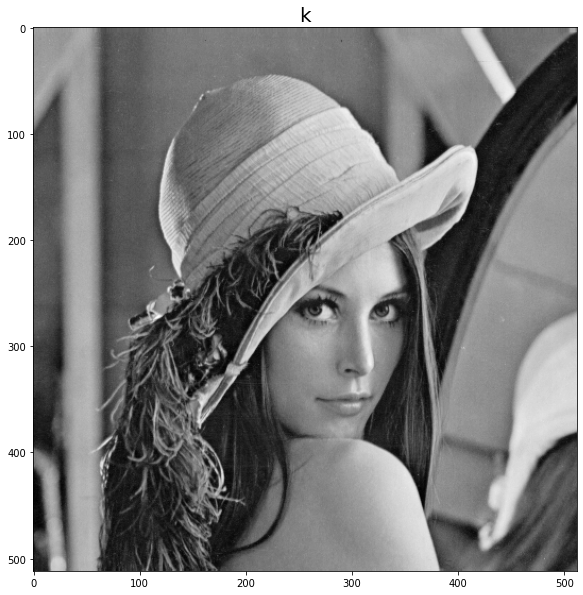

In [33]:
gray_image.show_normalized(indexes, "k")

In [34]:
decoded_img = centroids[indexes]#.astype(np.uint8)

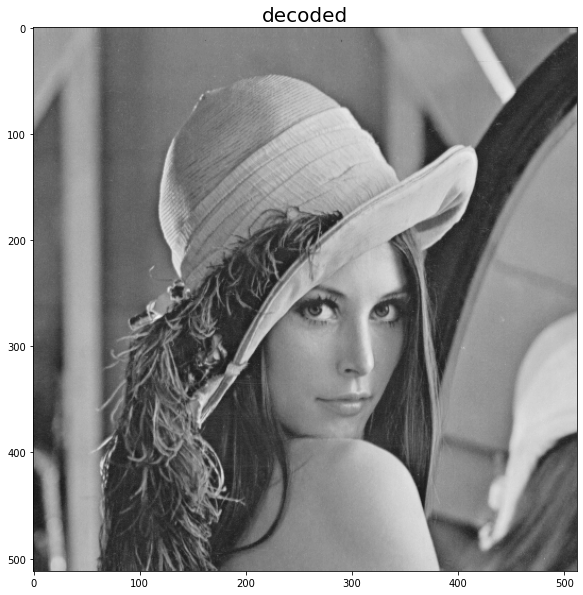

In [35]:
gray_image.show(decoded_img, "decoded")

## Using the library

In [36]:
import LloydMax_quantization as quantization

In [37]:
Q_step = 128
quantizer = quantization.LloydMax_Quantizer
Q = quantizer(Q_step=Q_step, counts=histogram)
print("decision_levels =", Q.get_decision_levels())
print("representation_levels =", Q.get_representation_levels())

decision_levels = [  0. 123. 255.]
representation_levels = [ 83.51391522 162.81212691]


In [38]:
#quantized_img, indexes = Q.encode_and_decode(img.flatten())
quantized_img, indexes = Q.encode_and_decode(img)

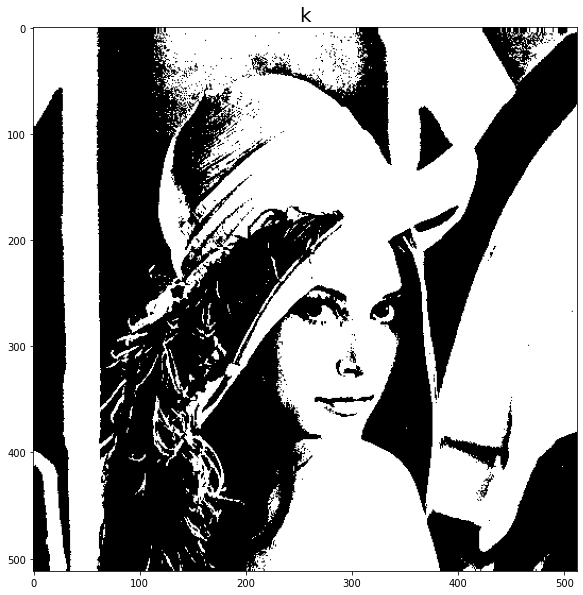

In [39]:
#gray_image.show_normalized(indexes.reshape(img.shape), fn + "000.png")
gray_image.show_normalized(indexes, "k")

In [40]:
def plot(x, y, xlabel='', ylabel='', title=''):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    ax.plot(x, y)
    plt.show(block=False)

In [41]:
histogram.shape

(256,)

In [42]:
x = np.linspace(0, 255, 256) # Input samples
x

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [43]:
x.shape

(256,)

In [44]:
Q = quantizer(Q_step=4, counts=histogram) # Use the histogram of lena

In [52]:
histogram

array([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    7,   22,   28,   63,   93,  135,  177,
        224,  306,  420,  508,  607,  778,  922, 1082, 1279, 1429, 1642,
       1756, 1846, 2038, 2066, 2007, 2081, 2053, 2039, 1969, 1846, 1741,
       1673, 1549, 1478, 1289, 1249, 1193, 1026,  959,  948,  910,  868,
        786,  801,  771,  776,  848,  812,  820,  801,  880,  903,  850,
        890,  938,  935,  916,  924,  847,  951,  935,  965,  994, 1015,
       1072, 1108, 1124, 1224, 1194, 1346, 1413, 1557, 1628, 1791, 1853,
       2105, 1930, 1899, 1941, 1840, 1763, 1737, 1588, 1498, 1466, 1336,
       1369, 1389, 1363, 1442, 1381, 1336, 1409, 1464, 1544, 1517, 1626,
       1789, 1790, 1878, 2061, 2097, 2311, 2300, 2385, 2483, 2390, 2262,
       2235, 2116, 1993, 1858, 1929, 1889, 2040, 2128, 2270, 2270, 2341,
       2433, 2466, 2409, 2214, 2340, 2285, 2202, 23

In [45]:
#k = Q.encode(x)
#k

array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  8,  8,
        8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16,
       17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21,
       21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25,
       25, 25, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29,
       29, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33,
       34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 37, 38,
       38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42,
       42, 42, 43, 43, 43, 43, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46,
       46, 47, 47, 47, 47, 48, 48, 48, 48, 49, 49, 49, 49, 50, 50, 50, 50,
       51, 51, 51, 51, 52, 52, 52, 52, 53, 53, 53, 53, 54, 54, 54, 54, 55,
       55, 55, 55, 56, 56

In [46]:
#Q.decode(np.array([1,2,64]))

In [47]:
#y = Q.decode(k)

In [48]:
y, k = Q.encode_and_decode(x)

In [49]:
k

array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  8,  8,
        8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16,
       17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21,
       21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25,
       25, 25, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29,
       29, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33,
       34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 37, 38,
       38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42,
       42, 42, 43, 43, 43, 43, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46,
       46, 47, 47, 47, 47, 48, 48, 48, 48, 49, 49, 49, 49, 50, 50, 50, 50,
       51, 51, 51, 51, 52, 52, 52, 52, 53, 53, 53, 53, 54, 54, 54, 54, 55,
       55, 55, 55, 56, 56

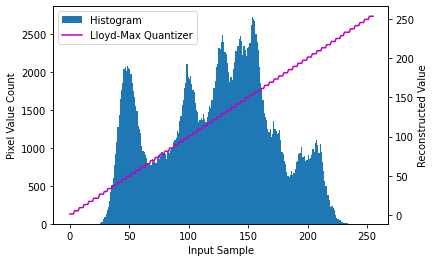

In [50]:
xlabel = "Input Sample"
ylabel = "Reconstructed Sample"
title = f"Lloyd-Max Quantizer ({fn}, $\Delta={Q_step}$)"

ax1 = plt.subplot()
counts, bins = np.histogram(img, range(257))
l1 = ax1.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
ax2 = ax1.twinx()
l2, = ax2.plot(x, y, color='m')

plt.legend([l1, l2], ["Histogram", "Lloyd-Max Quantizer"])
ax1.yaxis.set_label_text("Pixel Value Count")
ax2.yaxis.set_label_text("Reconstructed Value")
ax1.xaxis.set_label_text("Input Sample")
plt.show()

In [51]:
y

array([  1.5       ,   1.5       ,   1.5       ,   1.5       ,
         5.5       ,   5.5       ,   5.5       ,   5.5       ,
         9.5       ,   9.5       ,   9.5       ,   9.5       ,
        13.5       ,  13.5       ,  13.5       ,  13.5       ,
        17.5       ,  17.5       ,  17.5       ,  17.5       ,
        21.5       ,  21.5       ,  21.5       ,  21.5       ,
        21.5       ,  26.61290323,  26.61290323,  26.61290323,
        26.61290323,  30.05015674,  30.05015674,  30.05015674,
        33.85980479,  33.85980479,  33.85980479,  33.85980479,
        37.75097691,  37.75097691,  37.75097691,  37.75097691,
        41.66844624,  41.66844624,  41.66844624,  41.66844624,
        45.57280042,  45.57280042,  45.57280042,  45.57280042,
        49.50415648,  49.50415648,  49.50415648,  49.50415648,
        53.4313183 ,  53.4313183 ,  53.4313183 ,  53.4313183 ,
        57.40215633,  57.40215633,  57.40215633,  57.40215633,
        61.40281144,  61.40281144,  61.40281144,  61.40